# Makemore

Noted, Coded, and Created by Han Summer 2024. Part of The 20th Summer Project

------------
### Makemore

Making more things from the data given to the model.

Under the hood, **makemore is character level language model**, it means treating every single line example of data from the training set as a sequence of individual characters.

Character level language model, simpelnya cuman prediksi huruf yang selanjutnya berdasarkan sequence huruf yang udah ada (before it)

----
## This page is a the finished implementation of makemore model including Statistic Bigram, NN Bigram

In [1]:
import torch
import torch.nn.functional as F
import matplotlib.pyplot as plt

### Read Dataset

In [2]:
# Open the dataset (List of names) as a python list of strings which is words in this case
word= open('names.txt', 'r').read().splitlines()

In [3]:
N=torch.zeros((27,27),dtype=torch.int32)

#Make lookup table for character to index
chars=sorted(list(set(''.join(word)))) #Concat all the word in the dataset to 1 string, make it set which not allowing duplicate and sorted from a to z
#the index will start from 1 since index 0 will be used for start/end token
stoi={s:i+1 for i,s in enumerate(chars)} #Make dictionary of character to index {'a': 1, 'b': 2, 'c': 3, 'd': 4, and so on}
#Add start token and end token to the dictionary as a '.' and located in index 0
stoi['.']=0
#Inverse the matrix
itos={v:k for k,v in stoi.items()} 

### Bigram

In [28]:
def Bigram(word,namecount):

    for w in word:
        #Add start token and end token
        chs=['.']+list(w)+['.']
        for ch1, ch2 in zip(chs, chs[1:]): #Iterate with 2 characters at a time
            #Zip bakal stop ketika salah satu elemen habis, seperti chs[1:] habis duluan dibanding w
            ix1=stoi[ch1]
            ix2=stoi[ch2]
            #Counting up the occurence of the bigram
            N[ix1, ix2]+=1
    # g = torch.Generator().manual_seed(2147483647)
    
    
    P=(N+1).float() #Smoothing the model
    P=P/P.sum(1, keepdim=True)
    #for loop for how many names will be generated
    for i in range (namecount):
        out=[]
        ix=0
        while True:
            p=P[ix]
            #Generate the sample based on the probability in the row
            ix=torch.multinomial(p, num_samples=1, replacement=True).item()
            out.append(itos[ix])
            if ix==0: #This is when the char is '.' aka the end
                break
        print(''.join(out))


In [29]:
Bigram(word,10) #Generate 10 names

amciasanelarenthahin.
lirarinze.
fabe.
aimahinn.
bionielana.
n.
a.
malartalyon.
ziton.
mphelyadorudoarueilahkieestondriantolaliye.


### Bigram Neural Net

In [30]:
def NNBigram(epoch,learning_rate):
    
    #Create the training set of bigrams(x) and the target set of bigrams(y)
    xs, ys = [], []

    for w in word: #Iterate through all the bigrams
        #Add start token and end token
        chs=['.']+list(w)+['.']
        for ch1, ch2 in zip(chs, chs[1:]): #Iterate with 2 characters at a time
            #Zip bakal stop ketika salah satu elemen habis, seperti chs[1:] habis duluan dibanding w
            ix1=stoi[ch1]
            ix2=stoi[ch2]
            #Store the index value to the list
            xs.append(ix1)
            ys.append(ix2)
            
    #Convert to tensor (better to use lowercase "tensor" not "Tensor" since Tensor automatically assign the dtype to float32)
    xs=torch.tensor(xs)
    ys=torch.tensor(ys)    
    num = xs.nelement() #Number of element in the tensor
    
    # randomly initialize 27 neurons' weights. each neuron receives 27 inputs
    # g = torch.Generator().manual_seed(2147483647)
    W = torch.randn((27, 27), requires_grad=True) #requires_grad=True to make the weight can be updated by the optimizer
    
    #Model Training, gradient descent
    for i in range(epoch):
        #Forward pass
        xenc = F.one_hot(xs, num_classes=27).float() 
        logits = xenc @ W 
        counts = logits.exp()
        probs = counts / counts.sum(1, keepdims=True)
        loss=-probs[torch.arange(num), ys].log().mean()
        
        #Backward pass
        W.grad=None #Reset the gradient to zero
        loss.backward() #Calculate the gradient, torch is like micrograd, it tracks the computation graph
        
        #Update weight
        W.data += -learning_rate * W.grad
        if i % 10 == 0:
            print(f'Epoch {i}, Loss {loss.item()}')
            
    return W


In [31]:
#Model training
W=NNBigram(100,50)

Epoch 0, Loss 3.800018787384033
Epoch 10, Loss 2.659454107284546
Epoch 20, Loss 2.5612409114837646
Epoch 30, Loss 2.5260512828826904
Epoch 40, Loss 2.5074403285980225
Epoch 50, Loss 2.4960408210754395
Epoch 60, Loss 2.4883546829223633
Epoch 70, Loss 2.482818841934204
Epoch 80, Loss 2.4786510467529297
Epoch 90, Loss 2.4754178524017334


In [32]:
# Make the neural net do the character prediction
def predict_next_char(W):
    g = torch.Generator().manual_seed(2147483647)

    for i in range(5):
        out = []
        ix = 0
        while True:
            xenc = F.one_hot(torch.tensor([ix]), num_classes=27).float()
            logits = xenc @ W # predict log-counts
            counts = logits.exp() # counts, equivalent to N
            p = counts / counts.sum(1, keepdims=True) # probabilities for next character
            # ----------
            
            ix = torch.multinomial(p, num_samples=1, replacement=True).item()
            out.append(itos[ix])
            if ix == 0:
                break
        print(''.join(out))

In [33]:
predict_next_char(W)

s.
ly.
washja.
jan.
tlilytlo.


### Neural Network (Dataset split + GPU Support)

Predict next char based on 3 characters before

In [ ]:
block_size=3 #How many character used for prediction

In [4]:
def build_dataset(words):
    #Context size: berapa karakter sebelum yang dipake buat predict selanjutnya
    X, Y= [], []
    for w in words:
        # print(w)
        context=[0]*block_size #Padded context of 0 tokens -> [0]* 3 = [0,0,0] -> . . .
        for ch in w+'.':
            ix = stoi[ch]
            X.append(context)
            Y.append(ix)
            # print (''.join(itos[i] for i in context), '-->', itos[ix])
            context=context[1:]+[ix] #rolling window of the context, remove char in first idx and add new char in last idx
    #Convert to tensor
    X= torch.tensor(X)
    Y= torch.tensor(Y)
    
    print(X.shape, X.dtype, Y.shape, Y.dtype)
    return X,Y

In [5]:
#Dataset split
import random
random.seed(42)
random.shuffle(word)

In [8]:
n1= int(len(word)*0.8) #80% of the dataset
n2= int(len(word)*0.9) #90% of the dataset

X, Y= build_dataset(word)
Xtr,Ytr= build_dataset(word[:n1]) #Train
Xdev,Ydev= build_dataset(word[n1:n2]) #Validation -> 10% of the data (between 80% and 90% ; between Train and Test)
Xte,Yte= build_dataset(word[n2:]) #Test -> 10% of the data

torch.Size([228146, 3]) torch.int64 torch.Size([228146]) torch.int64
torch.Size([182625, 3]) torch.int64 torch.Size([182625]) torch.int64
torch.Size([22655, 3]) torch.int64 torch.Size([22655]) torch.int64
torch.Size([22866, 3]) torch.int64 torch.Size([22866]) torch.int64


In [7]:
#Move all to GPU
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
Xtr,Ytr,Xdev,Ydev,Xte,Yte = Xtr.to(device),Ytr.to(device),Xdev.to(device),Ydev.to(device),Xte.to(device),Yte.to(device)

In [10]:
# Initialization Parameters and Embedding
def init_params(embedding_dim, hidden_dim):
    #Embedding
    C= torch.randn((27, embedding_dim), device=device, requires_grad=True)
    #Parameters
    W1 = torch.randn(((block_size*embedding_dim), hidden_dim), device=device, requires_grad=True)
    b1 = torch.randn(hidden_dim, device=device, requires_grad=True)
    W2 = torch.randn((hidden_dim, 27), device=device, requires_grad=True)
    b2 = torch.randn(27, device=device, requires_grad=True)
    
    
    parameters=[C,W1,b1,W2,b2]
    
    return parameters, C, W1, b1, W2, b2

In [11]:
parameters, C, W1, b1, W2, b2 = init_params()
for p in parameters:
    p.requires_grad=True

In [ ]:
def checkloss(X,Y,parameters,embedding_dim=10):
    C,W1,b1,W2,b2=parameters
    C,W1,b1,W2,b2= C.to(device), W1.to(device), b1.to(device), W2.to(device), b2.to(device)
    X,Y= X.to(device), Y.to(device)
    emb = C[X]  
    h = torch.tanh(emb.view(-1, block_size*embedding_dim) @ W1 + b1)  
    logits = h @ W2 + b2  
    loss = F.cross_entropy(logits, Y) 
    return loss.item()

In [17]:
def makemodel(X,Y,parameters=None,learning_rate=0.1, nepochs=200000,embedding_dim=10, hidden_dim=100, batch_size=32):
    '''Default setting:
        Parameters is assigned for 10 embedding dimension and 100 hidden dimension
        Learning rate is 0.1
        Number of epochs is 200000
        Batch size is 32
    '''
    if parameters is None:
        parameters, C, W1, b1, W2, b2 = init_params(embedding_dim, hidden_dim)
        lossi = []
        stepi = []
    else:
        C,W1,b1,W2,b2=parameters
    X,Y,C= X.to(device), Y.to(device), C.to(device)
    
    for p in parameters: #Make sure all parameters requires grad from training
        p.requires_grad=True
    
    for i in range(nepochs):
        #Mini batch
        ix=torch.randint(0,X.shape[0],(batch_size,))
        #Forward pass
        emb = C[X[ix]]  
        h = torch.tanh(emb.view(-1, block_size*embedding_dim) @ W1 + b1)  
        logits = h @ W2 + b2  
        loss = F.cross_entropy(logits, Y[ix]) 
        
        #Backward pass
        for p in parameters:
            p.grad=None
        loss.backward()
        
        #Update parameters
        lr = 0.1 if i < 100000 else 0.01
        for p in parameters:
            p.data -= learning_rate*p.grad
            
        if i % 100 == 0:
            print(f'Epoch {i}, Loss {loss.item()}')
            
        #Track stats
        stepi.append(i)
        lossi.append(loss.log10().item())
        
        #Val and Test
        val_loss=checkloss(Xdev,Ydev,parameters)
        print(f'Validation Loss: {val_loss}')
        test_loss=checkloss(Xte,Yte,parameters)
        print(f'Test Loss: {test_loss}')
    return parameters, stepi, lossi

In [18]:
parameters, stepi, lossi = makemodel(Xtr,Ytr)

Epoch 0, Loss 18.395706176757812
Epoch 100, Loss 5.797088146209717
Epoch 200, Loss 5.593570709228516
Epoch 300, Loss 5.435478687286377
Epoch 400, Loss 3.420422315597534
Epoch 500, Loss 3.585432291030884
Epoch 600, Loss 2.8803346157073975
Epoch 700, Loss 2.8712680339813232
Epoch 800, Loss 3.2035350799560547
Epoch 900, Loss 3.364715814590454
Epoch 1000, Loss 3.535839557647705
Epoch 1100, Loss 3.362502098083496
Epoch 1200, Loss 3.3947689533233643
Epoch 1300, Loss 3.381350040435791
Epoch 1400, Loss 3.0366809368133545
Epoch 1500, Loss 2.9376344680786133
Epoch 1600, Loss 2.7235267162323
Epoch 1700, Loss 2.98065185546875
Epoch 1800, Loss 2.863079071044922
Epoch 1900, Loss 2.4845564365386963
Epoch 2000, Loss 2.579900026321411
Epoch 2100, Loss 2.936103582382202
Epoch 2200, Loss 2.6011102199554443
Epoch 2300, Loss 2.935004949569702
Epoch 2400, Loss 3.2049143314361572
Epoch 2500, Loss 2.8810014724731445
Epoch 2600, Loss 3.1495962142944336
Epoch 2700, Loss 2.783261299133301
Epoch 2800, Loss 2.6229

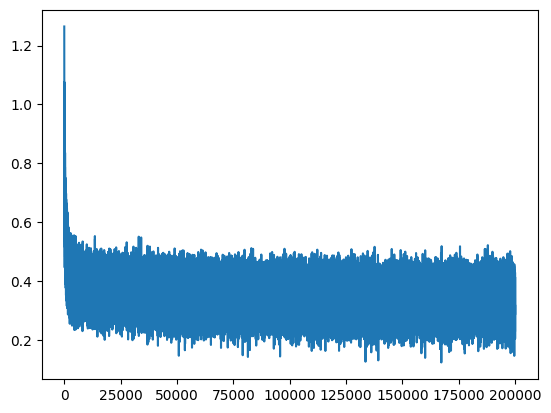

In [20]:
plt.plot(stepi,lossi)

In [24]:
#Create new word
def sample(parameters, n=5):
    # sample from the model
    block_size = 3
    C,W1,b1,W2,b2=parameters
    for _ in range(n):
        out = []
        context = [0] * block_size # initialize with all ...
        while True:
            emb = C[torch.tensor([context])] # (1,block_size,d)
            h = torch.tanh(emb.view(1, -1) @ W1 + b1)
            logits = h @ W2 + b2
            probs = F.softmax(logits, dim=1)
            ix = torch.multinomial(probs, num_samples=1).item()
            context = context[1:] + [ix]
            out.append(ix)
            if ix == 0:
                break
        
        print(''.join(itos[i] for i in out))

In [25]:
sample(parameters, 20)

yudharisson.
hor.
kmichan.
cuvaini.
ken.
iveenny.
riv.
jarseliah.
ema.
granser.
isabrisia.
eriam.
sylah.
jandrustela.
ploy.
deva.
isra.
mikacy.
rilius.
yazsabdi.
